In [1]:
from lib.threshold_tree import ThresholdTree
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer, load_diabetes

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

# Create dataset and perform Clustering

In [2]:
# This block is in progress

# data = pd.read_csv('datasets/diabetes.csv')
# data.head()

# X = data.drop(columns=['Outcome'])
# _y = data['Outcome']

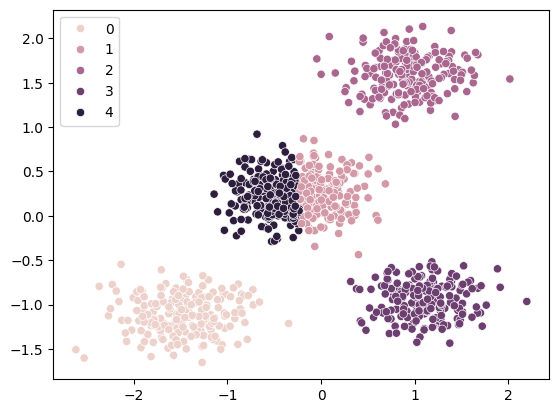

[[-0.38428901 -0.01819964]
 [-1.02692786 -1.26736657]
 [-1.43479399 -0.72002566]
 [ 0.90089717  1.82388419]
 [ 0.2453626   0.41377858]
 [-0.33501668  0.61609292]
 [ 1.01829246  1.65819426]
 [ 0.80556279 -0.80793046]
 [-0.68403135  0.92021168]
 [ 1.03873195 -1.13366733]]


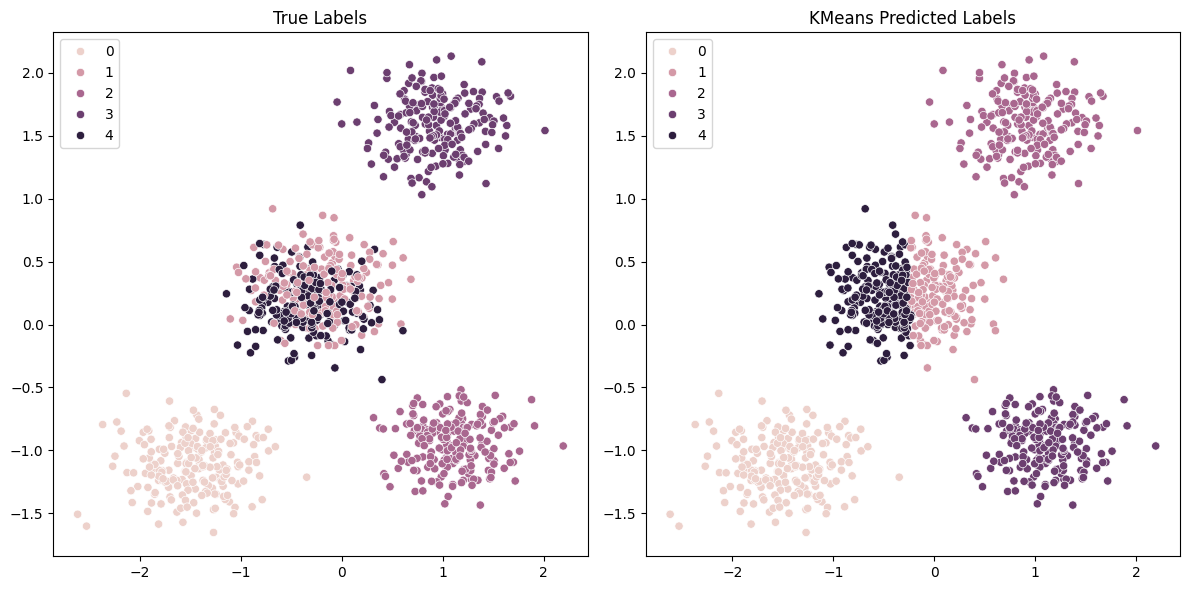

In [ ]:
dims = 2
n = 1000
k = 5
min_impurity_decrease = 0.1 # minimum impurity decrease to split for DTC
threshold_change = 0.01 # amount that will be changed to either side of the threshold
robustness_factor = 0.7 # DTC robustness post processing factor

X, _y = make_blobs(centers=k, cluster_std=1.4, n_features=dims, n_samples=n)
# data = load_iris()
# X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k)
model.fit(X)

centers = model.cluster_centers_
y = model.predict(X)
dims = X.shape[1]
n = X.shape[0]
k = len(centers)

# plot the clusters
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
else:
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')
plt.show()

print(X[:10])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with true labels
if dims > 2:
    sns.scatterplot(ax=axes[0], x=embed_X[:, 0], y=embed_X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")
else:
    sns.scatterplot(ax=axes[0], x=X[:, 0], y=X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")

# Plot with KMeans labels
if dims > 2:
    sns.scatterplot(ax=axes[1], x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")
else:
    sns.scatterplot(ax=axes[1], x=X[:, 0], y=X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")

plt.tight_layout()
plt.show()

# Choose instance and target

In [77]:
# instance_index = np.argwhere(y == 3)[0][0]
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 0, point: [-1.02692786 -1.26736657]
Target center class: 2, point: [0.93246423 1.59310997]



# Find cfs using Decision Tree Classifier

DTC accuracy: 0.998

Instance: [-1.02692786 -1.26736657]
Instance prediction : [0]

CFS: [[-0.22008719  0.96016556]]
CF predictions:  [1]


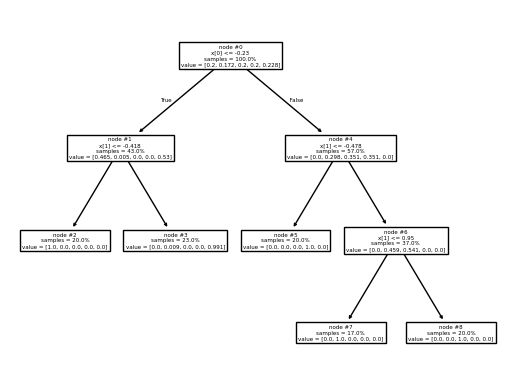

In [82]:
threshold_tree = ThresholdTree(model, centers, X, y)

cfs, cfs_prime = threshold_tree.find_counterfactuals_dtc(instance, target_class, min_impurity_decrease=min_impurity_decrease, threshold_change=threshold_change, robustness_factor=robustness_factor)
print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
print("")
print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
threshold_tree.print_dtc_tree()

# Find cfs using Iterative Mistake Minimization(IMM)

In [83]:
cf, cf_prime = threshold_tree.find_counterfactuals_imm(instance, target_class, threshold_change=threshold_change)
print("Instance: ", instance)
print("Counterfactual: ", cf)
print("")
print("Original class: ", model.predict([instance]))
print("Counterfactual class: ", model.predict(cf))
threshold_tree.print_imm_tree()

[1.60822376 1.60232965]
Instance:  [-1.02692786 -1.26736657]
Counterfactual:  [0.58129591 0.33496308]
Counterfactual':  [0.82711373 1.2156659 ]
Instance:  [-1.02692786 -1.26736657]
Counterfactual:  [[0.58129591 0.33496308]]

Original class:  [0]
Counterfactual class:  [1]
├── L0: f0 < -0.1892306660862615
│   ├── L1: f1 < -0.44600564409330695
│   │   ├── L2, C: 0
│   │   └── L2, C: 4
│   └── L1: f0 < 0.571295908857287
│       ├── L2, C: 1
│       └── L2: f1 < 0.3249630827128937
│           ├── L3, C: 3
│           └── L3, C: 2



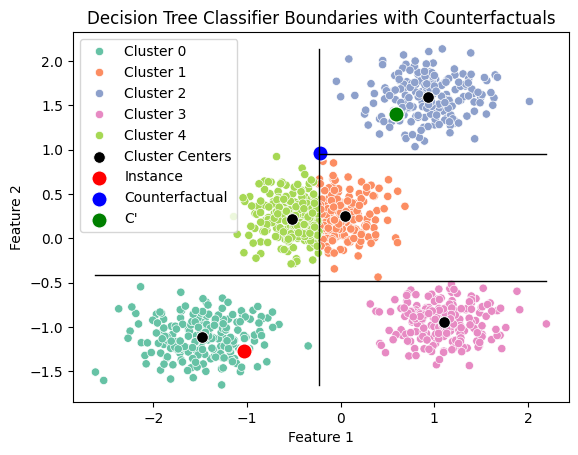

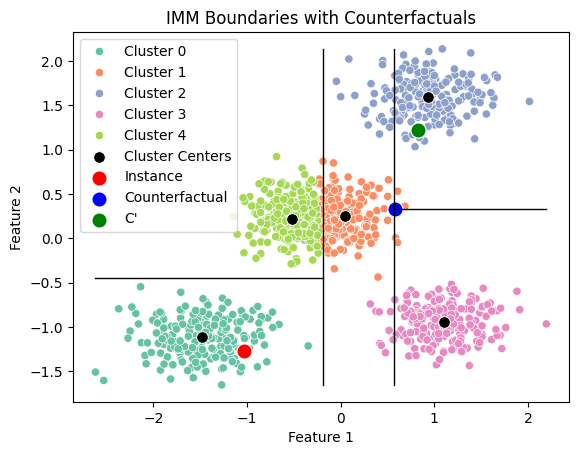

In [84]:
threshold_tree.plot_dtc_tree()
threshold_tree.plot_imm_tree()